# Classification of Genomic Structural Variants
## Structural Variant Mixture Model

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import geom, norm
import statsmodels.api as sm
from sklearn.cluster import KMeans as km
from sklearn.mixture import GaussianMixture as GMM
import sklearn.metrics as metrics
import random
import math

### Expectation Maximization

In [2]:
# TODO: UNDER CONSTRUCTION

# Plot the results from running the modified expectation maximization algorithm, for the two mode model
# - the mixture model comprises of a hurdle model for the first mode, with a zero-inflated component and a geometric component for noise
# - the second mode is a normal distribution, with some mu_2 and sigma_2
# - the plots ensure that there is weight given to the geometric representing noise; otherwise, all of the weight goes towards the zero-inflation
# - if there is indeed not all weight going towards zero-inflation, we may represent the geometric as well as the normal distribution
# - display the model histogram
# - display 2-mode structural variant mixture model scatter
# - display the affinities associated with each mode in the mixture model

# TODO: patch nan values in meaningful way
# TODO: improve visualization of model against histogram

def plot_SVEM_2mode(alpha,pi,l,mu,sigma,r,N, show_affinity_plot, ax):
    if math.isnan(pi[0]):
        X = [0 for _ in range(N)]
    else:
        X = [0 for _ in range(int(pi[0]*N*alpha))]
        if alpha != 1:
            X_l = stats.geom.rvs(1/l, size=(int(N*(1-alpha)*pi[0])))
            X.extend(X_l)
            X_g = np.random.normal(mu[0], sigma[0], int(pi[1]*N))
            X_g = [round(g) for g in X_g]
            X.extend(X_g)

    hist_1, bin_edges_1 = np.histogram(X, bins=20, density=False)
    bin_center_1 = (bin_edges_1[:-1] + bin_edges_1[1:])/2
    plt.scatter(bin_center_1, hist_1, color = 'orange')
    
    if(show_affinity_plot):
        fig_1, ax_1 = plt.subplots(figsize = (6,6))
        ax_1.set_yscale("log")
        plt.xlabel('Affinity')
        plt.ylabel('Number of Samples')
        plt.hist(r[0], alpha = 0.5)
        plt.hist(r[1], alpha = 0.5)
        plt.show()

In [3]:
# Modifying the expectation maximization algorithm from running on a Gaussian mixture model to one that better fits SVs
# - first iteration will replace the first mode with a hurdle model and drop the third mode (a normal distribution)
# - the parameters introduced in the hurdle model involve alpha, the proportion of zeros relative to all data points
# - the other parameter introduced is lambda, a variable that represents the expected value for # of trials until first success in a geometric
# - recall that other relevant parameters are mu, the mean of the normal distribution, and sigma, the std of the normal
# - another relevant parameter is pi, the mixing coefficient, related to the weight given to each mode, and r, the responsibility matrix

# TODO: find better initial approximations
# TODO: condense and improve flow, convert to OOP?

def SVEM_2mode(data, plot_it, show_affinity_plot, ax): 
    def dist(a,b):
        return np.abs(b - a)
    N = len(data)
    f = np.ravel(data).astype(float)
    f=f.reshape(-1,1)
    kmeans = km(n_clusters=2)
    kmeans.fit(f)
    centers = np.sort(np.ravel(kmeans.cluster_centers_))
    mu = centers
    mu = np.delete(mu, 0)
    sigma = [np.std(data)]
    pi = np.ones(2) * (1.0/2) 
    r = np.zeros([2,N]) 
    ll_list = list()
    iteration = 0
    distance = 1
    num_zeros = np.count_nonzero(data == 0)
    alpha = num_zeros / len(data) 
    l = 2

    while distance > (1 / (N*10)): 
        r_zero = []
        for i in range(len(data)):
            if data[i]==0:
                r_zero.append(alpha*pi[0])
            else:
                geo = stats.geom.pmf(data[i],1/l)
                r_zero.append(geo*(1-alpha)*pi[0])
                
        r[0] = r_zero
        r[1] = pi[1] * stats.norm.pdf(x=data, loc=mu[0], scale=sigma[0]) 
        for idx, r_i in enumerate(r[0]):
            if r_i == 0 or math.isnan(r_i):
                r[0][idx] = 1e-10
        for idx, r_i in enumerate(r[1]):
            if r_i == 0 or math.isnan(r_i):
                r[1][idx] = 1e-10
        r = r / np.sum(r, axis=0) 

        N_k = np.sum(r, axis=1)
        r_sum = 0
        for i in range(N):
            if data[i] == 0:
                r_sum += r[0][i]
        alpha = r_sum / sum(r[0])
        l_sum = 0
        for i in range(N):
            if data[i] != 0:
                l_sum += data[i] * r[0][i]
        if alpha != 1:
            l = l_sum / ((1-alpha)*sum(r[0]))
        else:
            l = 1e-3
        mu[0] = (np.sum(r[1] * data)) / N_k[1]  
        numerator = r[1] * (data - mu[0])**2
        sigma[0] = np.sqrt(np.sum(numerator) / N_k[1]) 
        if sigma[0] < 0.01:
            sigma[0] = 0.01
        pi = N_k/N

        likelihood_zero = (pi[0] * alpha) + (pi[1] * stats.norm.pdf(x = 0, loc = mu[0], scale = sigma[0]))
        likelihood = [likelihood_zero for _ in range(num_zeros)]
        for i in np.nonzero(data)[0]:
            nonzero_hurdle_likelihood = pi[0] * (1-alpha) * stats.geom.pmf(data[i], 1/l)
            likelihood.append(nonzero_hurdle_likelihood + (pi[1] * stats.norm.pdf(x = data[i], loc = mu[0], scale = sigma[0])))
        log_likelihood = np.sum(np.log(likelihood))
        ll_list.append(log_likelihood)
        
        iteration += 1
        if iteration > 1:
            distance = dist(ll_list[-1],ll_list[-2])
    if(plot_it):
        plot_SVEM_2mode(alpha,pi,l,mu,sigma,r,N, show_affinity_plot, ax)
    return alpha, l, ll_list

In [4]:
# Test the structural variant mixture model against synthetic data
# - generate data for zero-inflation, noise as a geometric distribution, and a normal distribution

# TODO: verify that conversion of points generated from Gaussian are rounded rather than truncated

N = 5000
a = 0.5
l = 2

X = [0 for _ in range(int(N*a))] # zero-inflation
X_l = stats.geom.rvs(1/l, size=(int(N*(1-a)))) # geometric distribution (p = 1/l, size)
X.extend(X_l)

X_g = np.random.normal(30, 3, 5000) # normal distribution (mu, std, size)
X_g = [round(g) for g in X_g] # convert to integers, in line with structural variant data
X.extend(X_g)

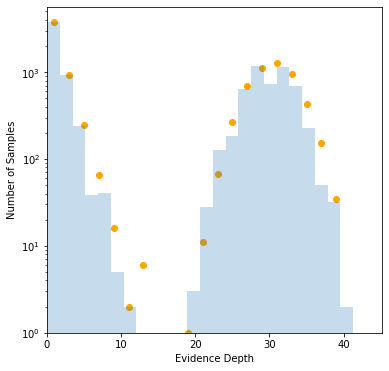

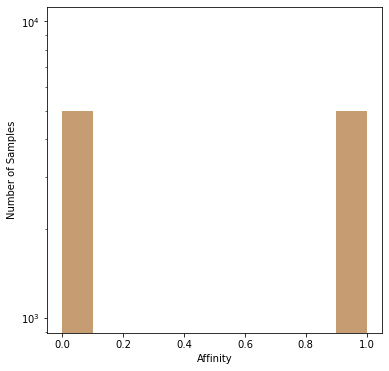

In [5]:
# Plot the original data, along with structural variant mixture model

fig, ax = plt.subplots(figsize = (6,6))

ax.hist(X, bins = 25, alpha = 0.25)
ax.set_yscale("log")
ax.set_ylim(bottom=1)
ax.set_xlim(left=0)
plt.xlabel('Evidence Depth')
plt.ylabel('Number of Samples')

alpha, l, ll_list = SVEM_2mode(np.array(X), True, True, ax)

301.4640814097693
392.22845218254315
100.11289517796376
1.2966751727808514
0.013046348635725735
0.00010876322448893916
8.883780537871644e-07


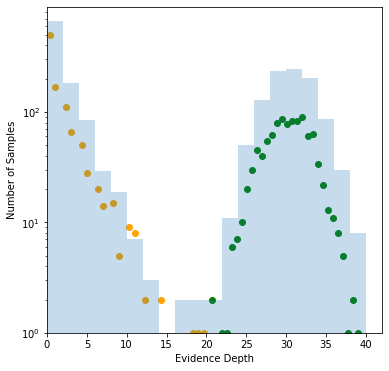

(array([0.5003612, 0.4996388]),
 0.49963905581843787,
 3.011267771182254,
 30.134960537567945,
 3.045003709961847)

In [6]:
from scipy.stats import norm, geom

def SVMM(X, show_plot):

    def plot_SVMM(X, N, pi, alpha, lambda_, mu, sigma):
        fig, ax = plt.subplots(figsize = (6,6))
        plt.hist(X, alpha = 0.25, bins = 20)

        X_hurdle = [0 for _ in range(int(pi[0] * N * alpha))]
        X_hurdle.extend(geom.rvs(1/lambda_, size = int(N * (1-alpha) * pi[0])))
        hist_hurdle, bin_hurdle = np.histogram(X_hurdle, bins = 30)
        plt.scatter(0.5 * (bin_hurdle[1:] + bin_hurdle[:-1]), hist_hurdle, color = 'orange')

        X_normal1 = norm.rvs(mu, sigma, size = int(pi[1] * N))
        hist_normal1, bin_normal1 = np.histogram(X_normal1, 30)
        plt.scatter(0.5 * (bin_normal1[1:] + bin_normal1[:-1]), hist_normal1, color = 'green')

        ax.set_yscale("log")
        ax.set_ylim(bottom=1)
        ax.set_xlim(left=0)
        plt.xlabel('Evidence Depth')
        plt.ylabel('Number of Samples')
        plt.show()

    N = np.shape(X)[0]
    pi = [1.0/2 for _ in range(2)]
    r = np.zeros([2,N]) 
    alpha = np.sum(X == 0) / N
    lambda_ = N / np.sum(X != 0) 
    sigma = np.std(X) 
    mu = np.mean(X)
    ll_list = []
    iteration = 0
    distance = 1

    while distance > (1/(N*10)):
        r[0][X==0] = pi[0] * alpha
        r[0][X!=0] = pi[0] * (1-alpha) * geom.pmf(X[X!=0], 1/lambda_)
        r[1] = pi[1] * norm.pdf(X, mu, sigma)
        r = r / np.sum(r, axis = 0)

        pi = np.sum(r, axis = 1) / N
        alpha = np.sum(r[0][X==0]) / np.sum(r[0])
        lambda_ = np.dot(X[X != 0], r[0][X != 0]) / ((1-alpha)*np.sum(r[0]))
        mu = np.average(X, weights = r[1])
        sigma = np.average((X-mu)**2, weights=r[1])**.5

        hurdle = np.where(X == 0, pi[0] * alpha, pi[0] * (1-alpha) * geom.pmf(X,1/lambda_))
        gmm = pi[1] * norm.pdf(X, mu, sigma)
        log_likelihood = np.sum(np.log(hurdle + gmm))
        ll_list.append(log_likelihood)

        iteration += 1
        if iteration > 1:
            distance = np.abs(ll_list[-2]-ll_list[-1])
            print(distance)

    if(show_plot):
        plot_SVMM(X, N, pi, alpha, lambda_, mu, sigma)

    return pi, alpha, lambda_, mu, sigma

N_gen = 1000
a_gen = 0.5
l_gen = 3

X = [0 for _ in range(int(N_gen*a_gen))]
X_l = geom.rvs(1/l_gen, size=(int(N_gen*(1-a_gen)))) 
X.extend(X_l)

X_g = np.random.normal(30, 3, 1000) 
X_g = [round(g) for g in X_g] 
X.extend(X_g)

X = np.array(X)

SVMM(X, True)

/var/folders/3v/8c4h0_nj36l6vkszy1szz5280000gn/T/ipykernel_38513/4220674881.py:18: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(f)
/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1835: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


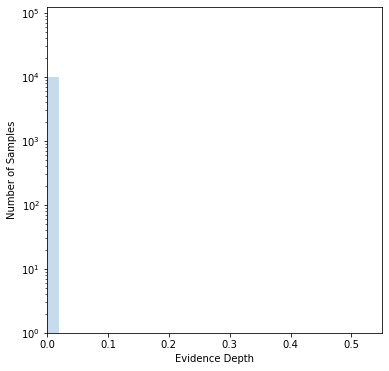

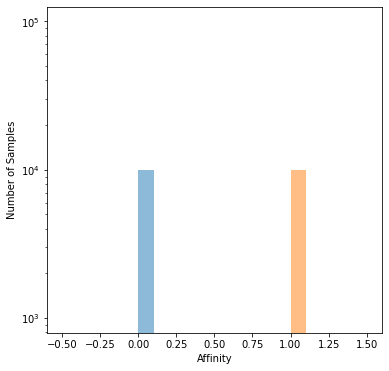

In [7]:
# Test the structural variant mixture model against edge cases
# Test 1: all zeros

N = 10000
X = [0 for _ in range(N)]

fig, ax = plt.subplots(figsize = (6,6))

ax.hist(X, bins = 25, alpha = 0.25)
ax.set_yscale("log")
ax.set_ylim(bottom=1)
ax.set_xlim(left=0)
plt.xlabel('Evidence Depth')
plt.ylabel('Number of Samples')

alpha, l, ll_list = SVEM_2mode(np.array(X), True, True, ax)

# TODO: improve model overlay

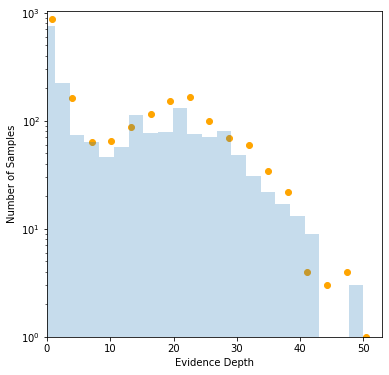

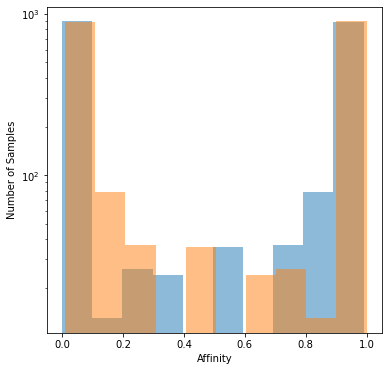

In [6]:
# Test 2: high overlap

N = 1000
a = 0.5
l = 2

X = [0 for _ in range(int(N*a))]
X_l = stats.geom.rvs(1/l, size=(int(N*(1-a))))

X.extend(X_l)
X_g = np.random.normal(20, 10, 1000) 
X_g = [int(g) for g in X_g]
X.extend(X_g)

fig, ax = plt.subplots(figsize = (6,6))

ax.hist(X, bins = 25, alpha = 0.25)
ax.set_yscale("log")
ax.set_ylim(bottom=1)
ax.set_xlim(left=0)
plt.xlabel('Evidence Depth')
plt.ylabel('Number of Samples')

alpha, l, ll_list = SVEM_2mode(np.array(X), True, True, ax)

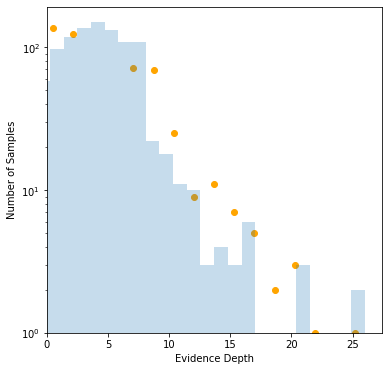

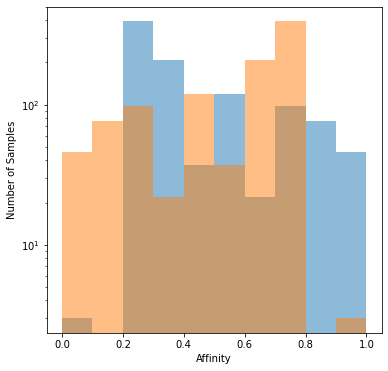

In [12]:
# Test 3: confusion with noise

N = 500
a = 0.1
l = 5

X = [0 for _ in range(int(N*a))]
X_l = stats.geom.rvs(1/l, size=(int(N*(1-a))))

X.extend(X_l)
X_g = np.random.normal(5, 2, 500)
X_g = [int(g) for g in X_g]
X.extend(X_g)

fig, ax = plt.subplots(figsize = (6,6))

ax.hist(X, bins = 25, alpha = 0.25)
ax.set_yscale("log")
ax.set_ylim(bottom=1)
ax.set_xlim(left=0)
plt.xlabel('Evidence Depth')
plt.ylabel('Number of Samples')

alpha, l, ll_list = SVEM_2mode(np.array(X), True, True, ax)

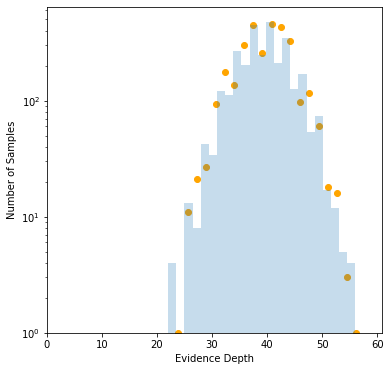

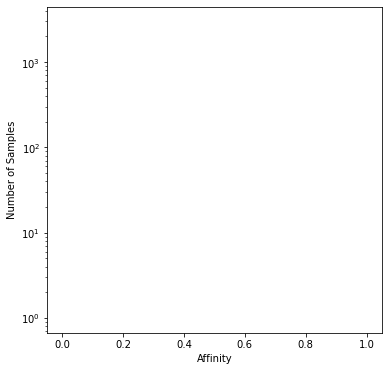

In [13]:
# Test 4: Gaussian-only, none from hurdle

X = []
X = np.random.normal(40, 5, 3000)
X = [int(x) for x in X]

fig, ax = plt.subplots(figsize = (6,6))

ax.hist(X, bins = 25, alpha = 0.25)
ax.set_yscale("log")
ax.set_ylim(bottom=1)
ax.set_xlim(left=0)
plt.xlabel('Evidence Depth')
plt.ylabel('Number of Samples')

alpha, l, ll_list = SVEM_2mode(np.array(X), True, True, ax)

# TODO: improve affinity display

In [43]:
# Plot the results from running the modified expectation maximization algorithm, for the full three mode model
# - the mixture model comprises of a hurdle model for the first mode, with a zero-inflated component and a geometric component for noise
# - the second mode is a normal distribution, with some mu_2 and sigma_2
# - the third mode is coupled with the second mode, in that mu_3 is twice mu_2, while sigma_3 is independent
# - the plots ensure that there is weight given to the geometric representing noise; otherwise, all of the weight goes towards the zero-inflation
# - if there is indeed not all weight going towards zero-inflation, we may represent the geometric as well as the normal distribution
# - display the model histogram
# - display 3-mode structural variant mixture model scatter
# - display the affinities associated with each mode in the mixture model

# TODO: patch nan values in meaningful way
# TODO: improve visualization of model against histogram

def plot_SVEM_3mode(alpha,pi,l,mu,sigma,r,N, show_affinity_plot, ax):
    if math.isnan(pi[0]):
        X = [0 for _ in range(N)]
    else:
        X = [0 for _ in range(int(pi[0]*N*alpha))]
        if alpha != 1:
            X_l = stats.geom.rvs(1/l, size=(int(N*(1-alpha)*pi[0])))
            X.extend(X_l)
            X_g = np.random.normal(mu[0], sigma[0], int(pi[1]*N))
            X_g = [int(g) for g in X_g]
            X.extend(X_g)
            X_a = np.random.normal(mu[1], sigma[1], int(pi[2]*N))
            X_a = [int(a) for a in X_a]
            X.extend(X_a)

    hist_1, bin_edges_1 = np.histogram(X, bins=30, density=False)
    bin_center_1 = (bin_edges_1[:-1] + bin_edges_1[1:])/2

    plt.scatter(bin_center_1, hist_1, color = 'orange')

    if(show_affinity_plot):
        fig_1, ax_1 = plt.subplots(figsize = (6,6))
        ax_1.set_yscale("log")
        plt.xlabel('Affinity')
        plt.ylabel('Number of Samples')
        # TODO: move the plots side by side
        plt.hist(r[0], alpha = 0.5, label = 'first mode') 
        plt.hist(r[1], alpha = 0.5, label = 'second mode')
        plt.hist(r[2], alpha = 0.5, label = 'third mode')
        plt.legend(loc="upper left")
        plt.show()

In [142]:
# Modifying the expectation maximization algorithm from running on a Gaussian mixture model to one that better fits SVs
# - first iteration will replace the first mode with a hurdle model
# - the parameters introduced in the hurdle model involve alpha, the proportion of zeros relative to all data points
# - the other parameter introduced is lambda, a variable that represents the expected value for # of trials until first success in a geometric
# - recall that other relevant parameters are mu_2, the mean of the normal distribution, and sigma_3, the std of the second mode
# - another relevenat parameter is mu_3, which is coupled to mu_2 by being twice its value, and sigma_3, the std of the third mode
# - another relevant parameter is pi, the mixing coefficient, related to the weight given to each mode, and r, the responsibility matrix

# TODO: find better initial approximations
# TODO: condense and improve flow, convert to OOP?
# TODO: couple third mode mu to second mode mu 

def SVEM_3mode(data, plot_it, show_affinity_plot, ax): 
    def dist(a,b):
        return np.abs(b - a)
    N = len(data)
    f = np.ravel(data).astype(float) 
    f=f.reshape(-1,1) # reshaping data so built-in kmeans can process data
    kmeans = km(n_clusters=3)
    kmeans.fit(f)
    centers = np.sort(np.ravel(kmeans.cluster_centers_))
    mu = centers # initial guess for mu 
    mu = np.delete(mu, 0) # not needed for first mode
    sigma = [np.std(data), np.std(data)] # initial guess for standard deviations 
    pi = np.ones(3) * (1.0/3) # initial weight across 3 modes
    r = np.zeros([3,N]) # responsibility matrix for 3 modes
    ll_list = list() # log-likelihood list
    iteration = 0
    distance = 1 # distance between log-likelihoods
    alpha = np.count_nonzero(data == 0) / len(data) # intial guess for proportion of zeros that comprise data
    l = 2 # expected value for first mode hurdle model geometric

    while distance > (1 / (N*10)): # tolerance
        r_zero = [] # affinity for first mode 
        for i in range(len(data)): # for each data point
            if data[i]==0: 
                r_zero.append(alpha*pi[0]) # if the data point is a 0, set affinity to proportion of zeros times first mode weight 
            else: 
                geo = stats.geom.pmf(data[i],1/l) # otherwise, the data point is noise and its affinity is associated with
                                                  # its geometric pmf and expected value
                r_zero.append(geo*(1-alpha)*pi[0]) # the noise affinity is geometric pmf (w/ inverse expected value)
                                                   # * proportion of nonzero * first mode weight
                
        r[0] = r_zero # set responsibility matrix row associated with first mode to found affinities
        r[1] = pi[1] * stats.norm.pdf(x=data, loc=mu[0], scale=sigma[0]) # second mode responsibility is equal to
                                                                         # normal pdf (w/ mu_2, sigma_3)
        r[2] = pi[2] * stats.norm.pdf(x=data, loc=mu[1], scale=sigma[1]) # third mode responsibility is equal to 
                                                                         # normal pdf (w/ mu_3, sigma_3)
        # TODO: condense this to one for-loop
        # background affinity to prevent numerical errors
        for idx, r_i in enumerate(r[0]):
            if r_i == 0 or math.isnan(r_i):
                r[0][idx] = 1e-10
        for idx, r_i in enumerate(r[1]):
            if r_i == 0 or math.isnan(r_i):
                r[1][idx] = 1e-10
        for idx, r_i in enumerate(r[2]):
            if r_i == 0 or math.isnan(r_i):
                r[2][idx] = 1e-10
        r = r / np.sum(r, axis=0) # normalize responsibility matrix

        N_k = np.sum(r, axis=1) 
        r_sum = 0 
        for i in range(N): 
            if data[i] == 0: # I(x_i = 0) -> {1 if x_i = 0, 0 otherwise}; given that the indicator variable returns 1
                r_sum += r[0][i] # take the sum of the responsibilities for each point in the first mode
        alpha = r_sum / sum(r[0])   # take the proportion of the sum of responsibilites which have an associated x_i = 0 
                                    # over the sum of all first mode responsibilites
        l_sum = 0
        for i in range(N): 
            if data[i] != 0: # I(x_i != 0) -> {1 if x_i != 0, 0 otherwise}; given that the indicator variable returns 1
                l_sum += data[i] * r[0][i] # take the sum of responsibilities for each point in the first mode * each data point
        if alpha != 1: # if the hurdle model doesn't only have zero-inflation; if not all data points are zero
            l = l_sum / ((1-alpha)*sum(r[0])) # take the proportion of the sum of responsibilites for each point in first mode * each data point
                                              # which have an associated x_i = 0
                                              # over the proportion of non-zero elements * sum of all first mode responsibilites
                                              # as this equation is based on the MLE for p in Geo(p), and l = 1/p
        else:
            l = 1e-3 # lower-bound for expected value associated with geometric distribution

        # TODO: condense into one for-loop
        # MLEs for mean and standard deviations associated with normal distributions
        mu[0] = (np.sum(r[1] * data)) / N_k[1]  
        numerator = r[1] * (data - mu[0])**2
        sigma[0] = np.sqrt(np.sum(numerator) / N_k[1]) 
        if sigma[0] < 0.01: # lower-bound for standard deviation
            sigma[0] = 0.01
        mu[1] = (np.sum(r[2] * data)) / N_k[2]  
        numerator = r[2] * (data - mu[1])**2
        sigma[1] = np.sqrt(np.sum(numerator) / N_k[2]) 
        if sigma[1] < 0.01: # lower-bound for standard deviation
            sigma[1] = 0.01
        pi = N_k/N # update mixing coefficients / weights for each mode

        # pi = np.sum(r, axis = 1) / N # total responsibility of a component divided by total # of observations
        # alpha = np.sum(r[0][data==0]) / np.sum(r[0]) # MLE for 
        # if alpha != 1:
        #     l = np.dot(data[data != 0], r[0][data != 0]) / ((1-alpha)*np.sum(r[0])) # reciprocal of MLE for p in geometric distribution
        # else:
        #     l = 1e-3
        # mu[0] = np.average(data, weights = r[1]) # MLE for mean in normal distribution
        # mu[1] = np.average(data, weights = r[2])
        # sigma[0]= np.average((data-mu[0])**2, weights=r[1])**.5 # MLE for standard deviation in normal distribution
        # if sigma[0] < 0.01:
        #     sigma[0] = 0.01
        # sigma[1]= np.average((data-mu[1])**2, weights=r[2])**.5 # MLE for standard deviation in normal distribution
        # if sigma[1] < 0.01:
        #     sigma[1] = 0.01

        # TODO: what if there is no noise, only zero-inflation and normals? 

        # likelihood = 0.0
        # if alpha != 0: # given there are zeros in the data
        #     likelihood += pi[0] * np.count_nonzero(data == 0) * np.log(alpha) # log-likelihood of
        # if alpha != 1: # given the entire data set is not entirely comprised of zeros
        #     likelihood += pi[0] * np.count_nonzero(data) * (np.log(1-alpha) + np.log((1/l)))
        #     for j in range(N):
        #         if data[j] != 0:
        #             likelihood += pi[0]*(data[j]-1) * np.log(1-(1/l))
        #     likelihood += pi[1] * stats.norm.pdf(x=data, loc=mu[0], scale=sigma[0])
        #     likelihood += pi[2] * stats.norm.pdf(x=data, loc=mu[1], scale=sigma[1])
        hurdle = np.where(X == 0, pi[0] * alpha, pi[0] * (1-alpha) * stats.geom.pmf(data,1/l)) #  likelihood of each observation in hurdle model
        gmm = pi[1] * stats.norm.pdf(data, mu[0], sigma[0]) + pi[2] * stats.norm.pdf(data, mu[1], sigma[1])# likelihood of each observation in normal distribution
        log_likelihood = np.sum(np.log(hurdle + gmm)) # sum of log of likelihood of each observation
        ll_list.append(np.sum(log_likelihood))

        iteration += 1
        if iteration > 1:
            distance = dist(ll_list[-1],ll_list[-2])
            print(distance)
    if(plot_it):
        plot_SVEM_3mode(alpha,pi,l,mu,sigma,r,N, show_affinity_plot, ax)
    return alpha, l, ll_list

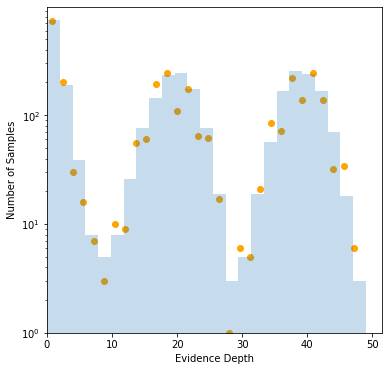

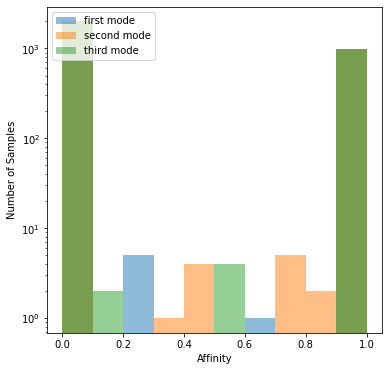

In [147]:
N = 1000
a = 0.5
l = 2

X = [0 for _ in range(int(N*a))]
X_l = stats.geom.rvs(1/l, size=(int(N*(1-a))))
X.extend(X_l)

X_g = np.random.normal(20, 3, 1000)
X_g = [int(g) for g in X_g]
X.extend(X_g)

X_g2 = np.random.normal(40, 3, 1000)
X_g2 = [int(g) for g in X_g2]
X.extend(X_g2)

fig, ax = plt.subplots(figsize = (6,6))

ax.hist(X, bins = 25, alpha = 0.25)
ax.set_yscale("log")
ax.set_ylim(bottom=1)
ax.set_xlim(left=0)
plt.xlabel('Evidence Depth')
plt.ylabel('Number of Samples')

alpha, l, ll_list = SVEM_3mode(np.array(X), True, True, ax)

/var/folders/3v/8c4h0_nj36l6vkszy1szz5280000gn/T/ipykernel_37078/2995350249.py:20: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(f)
/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1835: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


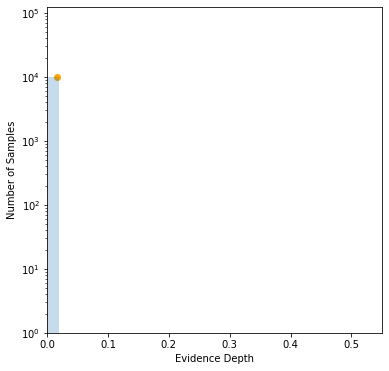

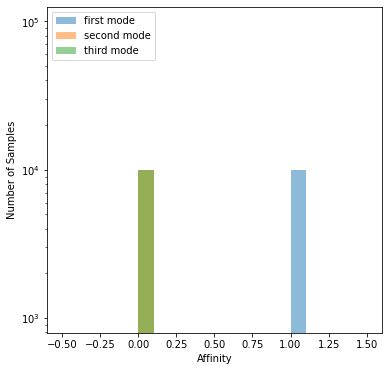

In [139]:
N = 10000
X = [0 for _ in range(N)]

fig, ax = plt.subplots(figsize = (6,6))

ax.hist(X, bins = 25, alpha = 0.25)
ax.set_yscale("log")
ax.set_ylim(bottom=1)
ax.set_xlim(left=0)
plt.xlabel('Evidence Depth')
plt.ylabel('Number of Samples')

alpha, l, ll_list = SVEM_3mode(np.array(X), True, True, ax)

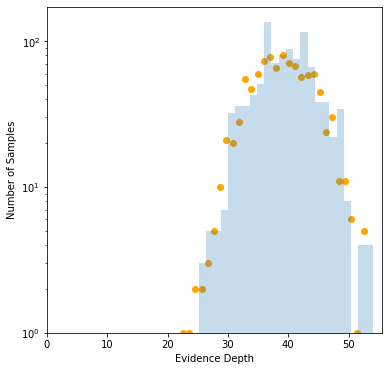

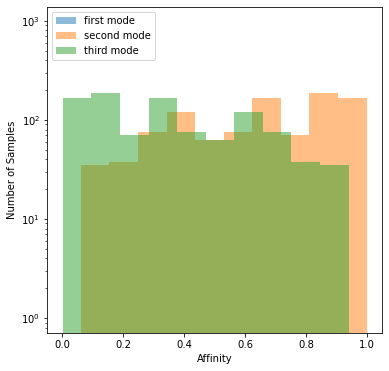

In [141]:
# Test 4: Guassian-only, none from hurdle (done)
X = []
X = np.random.normal(40, 5, 1000)
X = [int(x) for x in X]

fig, ax = plt.subplots(figsize = (6,6))

ax.hist(X, bins = 25, alpha = 0.25)
ax.set_yscale("log")
ax.set_ylim(bottom=1)
ax.set_xlim(left=0)
plt.xlabel('Evidence Depth')
plt.ylabel('Number of Samples')

alpha, l, ll_list = SVEM_3mode(np.array(X), True, True, ax)

### P-Value Calculation

In [119]:
def plot_SVEM_q0(data, alpha,l,r,N,ax):
    X_est = [0 for _ in range(int(N*alpha))]
    if alpha != 1:
        X_l_est = stats.geom.rvs(1/l, size=(int(N*(1-alpha))))
        X_est.extend(X_l_est)

    hist_1, bin_edges_1 = np.histogram(X_est, bins=20, density=False)
    bin_center_1 = (bin_edges_1[:-1] + bin_edges_1[1:])/2

    ax.scatter(bin_center_1, hist_1, color = 'orange')
    plt.show()

In [120]:
def SV_Plot(data,ax, show_plot): 
    def dist(a,b):
        return np.abs(b - a)
    N = len(data)
    # f = np.ravel(data).astype(float)
    # f=f.reshape(-1,1)
    # kmeans = km(n_clusters=2)
    # kmeans.fit(f)
    # centers = np.sort(np.ravel(kmeans.cluster_centers_))
    # mu = centers
    # mu = np.delete(mu, 0)
    # sigma = [np.std(data)]
    # pi = np.ones(2) * (1.0/2) 
    r = np.zeros([1,N]) 
    ll_list = list()
    iteration = 0
    distance = 1
    alpha = np.count_nonzero(data == 0) / len(data) 
    l = 2

    while distance > (1 / (N*10)): 
        r_zero = []
        for i in range(len(data)):
            if data[i]==0:
                r_zero.append(alpha)
            else:
                geo = stats.geom.pmf(data[i],1/l)
                r_zero.append(geo*(1-alpha))
        r[0] = r_zero
        # r[1] = pi[1] * stats.norm.pdf(x=data, loc=mu[0], scale=sigma[0]) 
        r = r / np.sum(r, axis=0) 

        # N_k = np.sum(r, axis=1)
        r_sum = 0
        for i in range(N):
            if data[i] == 0:
                r_sum += r[0][i]
        alpha = r_sum / sum(r[0])
        l_sum = 0
        for i in range(N):
            if data[i] != 0:
                l_sum += data[i] * r[0][i]
        l = l_sum / ((1-alpha)*sum(r[0]))
        # mu[0] = (np.sum(r[1] * data)) / N_k[1]  
        # numerator = r[1] * (data - mu[0])**2
        # sigma[0] = np.sqrt(np.sum(numerator) / N_k[1]) 
        # pi = N_k/N

        hurdle = np.where(X == 0, alpha, (1-alpha) * stats.geom.pmf(data,1/l))
        # for j in range(N):
        #     if data[j] != 0:
        #         likelihood += pi[0]*(data[j]-1) * np.log(1-(1/l))
        # likelihood += pi[1] * stats.norm.pdf(x=data, loc=mu[0], scale=sigma[0])
        ll_list.append(np.sum(hurdle))
        iteration += 1
        if iteration > 1:
            distance = dist(ll_list[-1],ll_list[-2])
    if(show_plot):
        plot_SVEM_q0(data, alpha, l, r, N,ax)
    return alpha, l

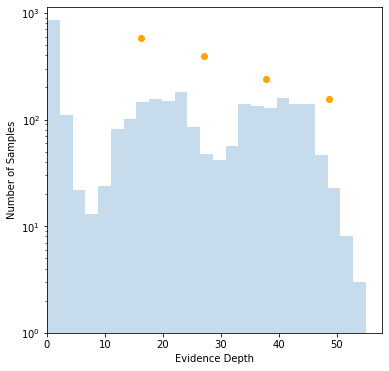

In [121]:
N = 1000
alpha = 0.5
l = 2

X = [0 for _ in range(int(N*alpha))]
X_l = stats.geom.rvs(1/l, size=(int(N*(1-alpha))))
X.extend(X_l)

X_g = np.random.normal(20, 5, 1000)
X_g = [int(g) for g in X_g]
X.extend(X_g)

X_g2 = np.random.normal(40, 5, 1000)
X_g2 = [int(g) for g in X_g2]
X.extend(X_g2)

fig, ax = plt.subplots(figsize = (6,6))

ax.hist(X, bins = 25, alpha = 0.25)
ax.set_yscale("log")
ax.set_ylim(bottom=1)
ax.set_xlim(left=0)
plt.xlabel('Evidence Depth')
plt.ylabel('Number of Samples')

alpha_q0, l_q0 = SV_Plot(np.array(X),ax, True)
d, p_val = stats.kstest(stats.geom.cdf(X, 1/l), stats.geom.cdf(X, 1/l_q0))

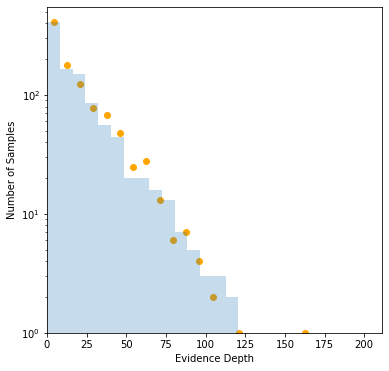

In [122]:
Y = [0 for _ in range(int(N*alpha_q0))]
Y_l = stats.geom.rvs(1/l_q0, size=(int(N*(1-alpha_q0))))
Y.extend(Y_l)

fig, ax = plt.subplots(figsize = (6,6))

ax.hist(Y, bins = 25, alpha = 0.25)
ax.set_yscale("log")
ax.set_ylim(bottom=1)
ax.set_xlim(left=0)
plt.xlabel('Evidence Depth')
plt.ylabel('Number of Samples')

alpha_q0, l_q0 = SV_Plot(np.array(Y),ax, True)
d, p_val = stats.kstest(stats.geom.cdf(Y, 1/l), stats.geom.cdf(Y, 1/l_q0))

In [123]:
def SV_Plot(data): 
    def dist(a,b):
        return np.abs(b - a)
    N = len(data)
    # f = np.ravel(data).astype(float)
    # f=f.reshape(-1,1)
    # kmeans = km(n_clusters=2)
    # kmeans.fit(f)
    # centers = np.sort(np.ravel(kmeans.cluster_centers_))
    # mu = centers
    # mu = np.delete(mu, 0)
    # sigma = [np.std(data)]
    # pi = np.ones(2) * (1.0/2) 
    r = np.zeros([1,N]) 
    ll_list = list()
    iteration = 0
    distance = 1
    alpha = np.count_nonzero(data == 0) / len(data) 
    l = 2

    while distance > (1 / (N*10)): 
        r_zero = []
        for i in range(len(data)):
            if data[i]==0:
                r_zero.append(alpha)
            else:
                geo = stats.geom.pmf(data[i],1/l)
                r_zero.append(geo*(1-alpha))
        r[0] = r_zero
        # r[1] = pi[1] * stats.norm.pdf(x=data, loc=mu[0], scale=sigma[0]) 
        r = r / np.sum(r, axis=0) 

        # N_k = np.sum(r, axis=1)
        r_sum = 0
        for i in range(N):
            if data[i] == 0:
                r_sum += r[0][i]
        alpha = r_sum / sum(r[0])
        l_sum = 0
        for i in range(N):
            if data[i] != 0:
                l_sum += data[i] * r[0][i]
        l = l_sum / ((1-alpha)*sum(r[0]))
        # mu[0] = (np.sum(r[1] * data)) / N_k[1]  
        # numerator = r[1] * (data - mu[0])**2
        # sigma[0] = np.sqrt(np.sum(numerator) / N_k[1]) 
        # pi = N_k/N

        hurdle = np.where(X == 0, alpha, (1-alpha) * stats.geom.pmf(data,1/l))
        # for j in range(N):
        #     if data[j] != 0:
        #         likelihood += pi[0]*(data[j]-1) * np.log(1-(1/l))
        # likelihood += pi[1] * stats.norm.pdf(x=data, loc=mu[0], scale=sigma[0])
        ll_list.append(np.sum(hurdle))
        iteration += 1
        if iteration > 1:
            distance = dist(ll_list[-1],ll_list[-2])
    return alpha, l

In [124]:
def refit_SVMM_q0(alpha_q0, l_q0):
    Y = [0 for _ in range(int(N*alpha_q0))]
    Y_l = stats.geom.rvs(1/l_q0, size=(int(N*(1-alpha_q0))))
    Y.extend(Y_l)
    return SV_Plot(np.array(Y))

In [136]:
p_vals = []
d_vals = []
for i in range(1000):
    alpha_new, l_new = refit_SVMM_q0(alpha_q0, l_q0)
    d = stats.kstest(stats.geom.cdf(Y, 1/l_new), stats.geom.cdf(Y, 1/l)).pvalue
    d_vals.append(d)
    print(i)
d_vals = np.mean(d_vals)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [137]:
print(d_vals)

7.391040380201199e-154


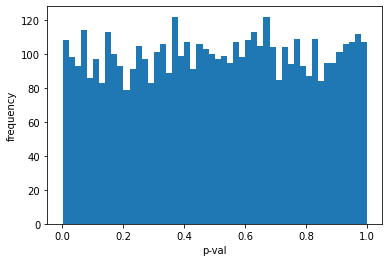

In [7]:
plt.hist(p_vals, 50)
plt.xlabel('p-val')
plt.ylabel('frequency')
plt.show()

### Model Comparison

In [72]:
def plot_SVEM_2mode(alpha,pi,l,mu,sigma,r,N):
    if math.isnan(pi[0]):
        X = [0 for _ in range(N)]
    else:
        X = [0 for _ in range(int(pi[0]*N*alpha))]
        if alpha != 1:
            X_l = stats.geom.rvs(1/l, size=(int(N*(1-alpha)*pi[0])))
            X.extend(X_l)
            X_g = np.random.normal(mu[0], sigma[0], int(pi[1]*N))
            X_g = [int(g) for g in X_g]
            X.extend(X_g)

    hist_1, bin_edges_1 = np.histogram(X, bins=20, density=False)
    bin_center_1 = (bin_edges_1[:-1] + bin_edges_1[1:])/2
    fig, ax = plt.subplots(figsize = (6,6))

    plt.hist(X, bins = 20, alpha = 0.25, rwidth = 1)   
    plt.scatter(bin_center_1, hist_1, color = 'orange')
    ax.set_yscale("log")
    ax.set_ylim(bottom=1)
    ax.set_xlim(left=0)
    plt.xlabel('Evidence Depth')
    plt.ylabel('Number of Samples')
    plt.show()
    fig_1, ax_1 = plt.subplots(figsize = (6,6))
    ax_1.set_yscale("log")
    plt.xlabel('Affinity')
    plt.ylabel('Number of Samples')
    plt.hist(r[0], alpha = 0.5)
    plt.hist(r[1], alpha = 0.5)
    plt.show()

In [76]:
def plot_SVEM_3mode(alpha,pi,l,mu,sigma,r,N):
    if math.isnan(pi[0]):
        X = [0 for _ in range(N)]
    else:
        X = [0 for _ in range(int(pi[0]*N*alpha))]
        if alpha != 1:
            X_l = stats.geom.rvs(1/l, size=(int(N*(1-alpha)*pi[0])))
            X.extend(X_l)
            X_g = np.random.normal(mu[0], sigma[0], int(pi[1]*N))
            X_g = [int(g) for g in X_g]
            X.extend(X_g)
            X_a = np.random.normal(mu[1], sigma[1], int(pi[2]*N))
            X_a = [int(a) for a in X_a]
            X.extend(X_a)

    hist_1, bin_edges_1 = np.histogram(X, bins=30, density=False)
    bin_center_1 = (bin_edges_1[:-1] + bin_edges_1[1:])/2
    fig, ax = plt.subplots(figsize = (6,6))

    plt.hist(X, bins = 20, alpha = 0.25, rwidth = 1)   
    plt.scatter(bin_center_1, hist_1, color = 'orange')
    ax.set_yscale("log")
    ax.set_ylim(bottom=1)
    ax.set_xlim(left=0)
    plt.xlabel('Evidence Depth')
    plt.ylabel('Number of Samples')
    plt.show()
    fig_1, ax_1 = plt.subplots(figsize = (6,6))
    ax_1.set_yscale("log")
    plt.xlabel('Affinity')
    plt.ylabel('Number of Samples')
    # TODO: move the plots side by side
    plt.hist(r[0], alpha = 0.5, label = 'first mode') 
    plt.hist(r[1], alpha = 0.5, label = 'second mode')
    plt.hist(r[2], alpha = 0.5, label = 'third mode')
    plt.legend(loc="upper left")
    plt.show()

In [73]:
def SVEM_2mode(data, plot_it): 
    def dist(a,b):
        return np.abs(b - a)
    N = len(data)
    f = np.ravel(data).astype(float)
    f=f.reshape(-1,1)
    kmeans = km(n_clusters=2)
    kmeans.fit(f)
    centers = np.sort(np.ravel(kmeans.cluster_centers_))
    mu = centers
    mu = np.delete(mu, 0)
    sigma = [np.std(data)]
    pi = np.ones(2) * (1.0/2) 
    r = np.zeros([2,N]) 
    ll_list = list()
    iteration = 0
    distance = 1
    alpha = np.count_nonzero(data == 0) / len(data) 
    l = 2

    while distance > (1 / (N*10)): 
        r_zero = []
        for i in range(len(data)):
            if data[i]==0:
                r_zero.append(alpha*pi[0])
            else:
                geo = stats.geom.pmf(data[i],1/l)
                r_zero.append(geo*(1-alpha)*pi[0])
                
        r[0] = r_zero
        r[1] = pi[1] * stats.norm.pdf(x=data, loc=mu[0], scale=sigma[0]) 
        for idx, r_i in enumerate(r[0]):
            if r_i== 0:
                r[0][idx] = 1e-10
        for idx, r_i in enumerate(r[1]):
            if r_i == 0 or math.isnan(r_i):
                r[1][idx] = 1e-10
        r = r / np.sum(r, axis=0) 

        N_k = np.sum(r, axis=1)
        r_sum = 0
        for i in range(N):
            if data[i] == 0:
                r_sum += r[0][i]
        alpha = r_sum / sum(r[0])
        l_sum = 0
        for i in range(N):
            if data[i] != 0:
                l_sum += data[i] * r[0][i]
        if alpha != 1:
            l = l_sum / ((1-alpha)*sum(r[0]))
        else:
            l = 1e-3
        mu[0] = (np.sum(r[1] * data)) / N_k[1]  
        numerator = r[1] * (data - mu[0])**2
        sigma[0] = np.sqrt(np.sum(numerator) / N_k[1]) 
        if sigma[0] < 0.01:
            sigma[0] = 0.01
        pi = N_k/N

        likelihood = 0.0
        if alpha != 0:
            likelihood += pi[0] * np.count_nonzero(data == 0) * np.log(alpha)
        if alpha != 1:
            likelihood += pi[0] * np.count_nonzero(data) * (np.log(1-alpha) + np.log((1/l)))
            for j in range(N):
                if data[j] != 0:
                    likelihood += pi[0]*(data[j]-1) * np.log(1-(1/l))
            likelihood += pi[1] * stats.norm.pdf(x=data, loc=mu[0], scale=sigma[0])
        ll_list.append(np.sum(likelihood))
        iteration += 1
        if iteration > 1:
            distance = dist(ll_list[-1],ll_list[-2])
    if(plot_it):
        plot_SVEM_2mode(alpha,pi,l,mu,sigma,r,N)
    return alpha, l, ll_list

In [131]:
def SVEM_3mode(data,plot_it): 
    def dist(a,b):
        return np.abs(b - a)
    N = len(data)
    f = np.ravel(data).astype(float)
    f=f.reshape(-1,1)
    kmeans = km(n_clusters=3)
    kmeans.fit(f)
    centers = np.sort(np.ravel(kmeans.cluster_centers_))
    mu = centers
    mu = np.delete(mu, 0)
    sigma = [np.std(data), np.std(data)]
    pi = np.ones(3) * (1.0/3) 
    r = np.zeros([3,N]) 
    ll_list = list()
    iteration = 0
    distance = 1
    alpha = np.count_nonzero(data == 0) / len(data) 
    l = 2

    while distance > (1 / (N*10)): 
        r_zero = []
        for i in range(len(data)):
            if data[i]==0:
                r_zero.append(alpha*pi[0])
            else:
                geo = stats.geom.pmf(data[i],1/l)
                r_zero.append(geo*(1-alpha)*pi[0])
                
        r[0] = r_zero
        r[1] = pi[1] * stats.norm.pdf(x=data, loc=mu[0], scale=sigma[0])
        r[2] = pi[2] * stats.norm.pdf(x=data, loc=mu[1], scale=sigma[1])

        # TODO: condense this to one for-loop
        for idx, r_i in enumerate(r[0]):
            if r_i== 0:
                r_i[idx] = 1e-10
        for idx, r_i in enumerate(r[1]):
            if r_i == 0 or math.isnan(r_i):
                r[1][idx] = 1e-10
        for idx, r_i in enumerate(r[2]):
            if r_i == 0 or math.isnan(r_i):
                r[2][idx] = 1e-10
        r = r / np.sum(r, axis=0) 

        N_k = np.sum(r, axis=1)
        r_sum = 0
        for i in range(N):
            if data[i] == 0:
                r_sum += r[0][i]
        alpha = r_sum / sum(r[0])
        l_sum = 0
        for i in range(N):
            if data[i] != 0:
                l_sum += data[i] * r[0][i]
        if alpha != 1:
            l = l_sum / ((1-alpha)*sum(r[0]))
        else:
            l = 1e-3
        # TODO: condense into one for-loop
        mu[0] = (np.sum(r[1] * data)) / N_k[1]  
        numerator = r[1] * (data - mu[0])**2
        sigma[0] = np.sqrt(np.sum(numerator) / N_k[1]) 
        if sigma[0] < 0.01:
            sigma[0] = 0.01
        mu[1] = (np.sum(r[2] * data)) / N_k[2]  
        numerator = r[2] * (data - mu[1])**2
        sigma[1] = np.sqrt(np.sum(numerator) / N_k[2]) 
        if sigma[1] < 0.01:
            sigma[1] = 0.01
        pi = N_k/N

        likelihood = 0.0
        if alpha != 0:
            likelihood += pi[0] * np.count_nonzero(data == 0) * np.log(alpha)
        if alpha != 1:
            likelihood += pi[0] * np.count_nonzero(data) * (np.log(1-alpha) + np.log((1/l)))
            for j in range(N):
                if data[j] != 0:
                    likelihood += pi[0]*(data[j]-1) * np.log(1-(1/l))
            likelihood += pi[1] * stats.norm.pdf(x=data, loc=mu[0], scale=sigma[0])
            likelihood += pi[2] * stats.norm.pdf(x=data, loc=mu[1], scale=sigma[1])
        ll_list.append(np.sum(likelihood))
        iteration += 1
        if iteration > 1:
            distance = dist(ll_list[-1],ll_list[-2])
    
    if(plot_it):
        plot_SVEM_3mode(alpha,pi,l,mu,sigma,r,N)
    return alpha, l, ll_list

In [132]:
N = 1000
a = 0.5
l = 2

X = [0 for _ in range(int(N*a))]
X_l = stats.geom.rvs(1/l, size=(int(N*(1-a))))

X.extend(X_l)
X_g = np.random.normal(30, 5, 1000)
X_g = [int(g) for g in X_g]
X.extend(X_g)

alpha_2mode, l_2mode, ll_2mode = SVEM_2mode(np.array(X), False)
alpha_3mode, l_3mode, ll_3mode = SVEM_3mode(np.array(X), False)

# verify that in the case of the nested model, that the likelihoods are close together
# look into VC dimensions on free time

KeyboardInterrupt: 

In [10]:
def plot_SVMM_2mode(X, n, pi, alpha, lambda_, mu, sigma):
    ax = plt.subplots(figsize = (6,6))[1]
    plt.hist(X, alpha = 0.5, bins = 20) # plot histogram of input data set

    X_hurdle = [0 for _ in range(n)]
    X_hurdle = [0 for _ in range(int(pi[0] * n * alpha))] # generate zeros based on estimated parameters
    X_hurdle.extend(geom.rvs(1/lambda_, size = int(n * (1-alpha) * pi[0]))) # generate geometric based on estimated parameters
    hist_hurdle, bin_hurdle = np.histogram(X_hurdle, bins = 30) # derive points and bin edges in histogram form
    plt.scatter(0.5 * (bin_hurdle[1:] + bin_hurdle[:-1]), hist_hurdle, color = 'orange') # plot points against bin centers

    X_normal1 = norm.rvs(mu, sigma, size = int(pi[1] * n)) # generate normal based on estimated parameters
    hist_normal1, bin_normal1 = np.histogram(X_normal1, 30) # derive points and bin edges in histogram form
    plt.scatter(0.5 * (bin_normal1[1:] + bin_normal1[:-1]), hist_normal1, color = 'green') # plot points against bin centers

    ax.set_yscale("log") 
    ax.set_ylim(bottom=1)
    ax.set_xlim(left=0)
    plt.xlabel('Evidence Depth')
    plt.ylabel('Number of Samples')
    plt.show()

def SVMM_2mode(X, show_plot, show_distance):

    # TODO: fine-tune initial paramters, put in separate function
    # initial values for parameters
    n = np.shape(X)[0] # length of data set
    pi = [1.0/2 for _ in range(2)] # mixing coefficients
    r = np.zeros([2,n]) # responsibility matrix
    alpha = np.sum(X == 0) / n # probability of an observation belonging to zero component
    lambda_ = n / np.sum(X != 0) # expected value of the geometric distribution
    sigma = np.std(X) # standard deviation for normal distribution
    mu = np.mean(X) # mean for normal distribution 
    log_likelihoods = [] 
    iteration = 0
    distance = 1

    while distance > (1/(n*10)): # convergence criterion

        # expectation
        r[0][X==0] = pi[0] * alpha # responsibility of zero values to first mode
        r[0][X!=0] = pi[0] * (1-alpha) * geom.pmf(X[X!=0], 1/lambda_) # responsibility of nonzero values to first component
        r[1] = pi[1] * norm.pdf(X, mu, sigma) # responsibility of each value to second component
        r = r / np.sum(r, axis = 0) # normalization

        # maximization
        pi = np.sum(r, axis = 1) / n # total responsibility of a component divided by total # of observations
        alpha = np.sum(r[0][X==0]) / np.sum(r[0]) # MLE for 
        lambda_ = np.dot(X[X != 0], r[0][X != 0]) / ((1-alpha)*np.sum(r[0])) # reciprocal of MLE for p in geometric distribution
        mu = np.average(X, weights = r[1]) # MLE for mean in normal distribution
        sigma = np.average((X-mu)**2, weights=r[1])**.5 # MLE for standard deviation in normal distribution

        # score
        hurdle = np.where(X == 0, pi[0] * alpha, pi[0] * (1-alpha) * geom.pmf(X,1/lambda_)) #  likelihood of each observation in hurdle model
        gmm = pi[1] * norm.pdf(X, mu, sigma) # likelihood of each observation in normal distribution
        log_likelihood = np.sum(np.log(hurdle + gmm)) # sum of log of likelihood of each observation
        log_likelihoods.append(log_likelihood) 

        iteration += 1
        if iteration > 1:
            distance = np.abs(log_likelihoods[-2]-log_likelihoods[-1]) # magnitude of difference between each 
            if(show_distance):
                print(distance)

    if(show_plot):
        plot_SVMM_2mode(X, n, pi, alpha, lambda_, mu, sigma)

    return pi, alpha, lambda_, mu, sigma, log_likelihoods

In [1]:
def plot_SVMM_3mode(X, n, pi, alpha, lambda_, mu, sigma):
    ax = plt.subplots(figsize = (6,6))[1]
    plt.hist(X, alpha = 0.5, bins = 20) # plot histogram of input data set

    X_hurdle = [0 for _ in range(n)]
    X_hurdle = [0 for _ in range(int(pi[0] * n * alpha))] # generate zeros based on estimated parameters
    X_hurdle.extend(geom.rvs(1/lambda_, size = int(n * (1-alpha) * pi[0]))) # generate geometric based on estimated parameters
    hist_hurdle, bin_hurdle = np.histogram(X_hurdle, bins = 30) # derive points and bin edges in histogram form
    plt.scatter(0.5 * (bin_hurdle[1:] + bin_hurdle[:-1]), hist_hurdle, color = 'orange') # plot points against bin centers

    X_normal1 = norm.rvs(mu[0], sigma[0], size = int(pi[1] * n)) # generate normal based on estimated parameters
    hist_normal1, bin_normal1 = np.histogram(X_normal1, 30) # derive points and bin edges in histogram form
    plt.scatter(0.5 * (bin_normal1[1:] + bin_normal1[:-1]), hist_normal1, color = 'green') # plot points against bin centers

    X_normal2 = norm.rvs(mu[1], sigma[1], size = int(pi[2] * n)) # generate normal based on estimated parameters
    hist_normal2, bin_normal2 = np.histogram(X_normal2, 30) # derive points and bin edges in histogram form
    plt.scatter(0.5 * (bin_normal2[1:] + bin_normal2[:-1]), hist_normal2, color = 'purple') # plot points against bin centers

    ax.set_yscale("log") 
    ax.set_ylim(bottom=1)
    ax.set_xlim(left=0)
    plt.xlabel('Evidence Depth')
    plt.ylabel('Number of Samples')
    plt.show()

def SVMM_3mode(X, show_plot, show_distance):

    # TODO: fine-tune initial paramters, put in separate function
    # initial values for parameters
    n = np.shape(X)[0] # length of data set
    pi = [1.0/3 for _ in range(3)] # mixing coefficients
    r = np.zeros([3,n]) # responsibility matrix
    alpha = np.sum(X == 0) / n # probability of an observation belonging to zero component
    lambda_ = n / np.sum(X != 0) # expected value of the geometric distribution
    sigma = [np.std(X), np.std(X)] # standard deviation for normal distribution
    f = np.ravel(X).astype(float)
    f=f.reshape(-1,1)
    kmeans = km(n_clusters=3)
    kmeans.fit(f)
    centers = np.sort(np.ravel(kmeans.cluster_centers_))
    mu = centers
    mu = np.delete(mu, 0)
    log_likelihoods = [] 
    iteration = 0
    distance = 1

    while distance > (1/(n*10)): # convergence criterion

        # expectation
        r[0][X==0] = pi[0] * alpha # responsibility of zero values to first mode
        r[0][X!=0] = pi[0] * (1-alpha) * geom.pmf(X[X!=0], 1/lambda_) # responsibility of nonzero values to first component
        r[1] = pi[1] * norm.pdf(X, mu[0], sigma[0]) # responsibility of each value to second component
        r[2] = pi[2] * norm.pdf(X, mu[1], sigma[1]) # responsibility of each value to second component
        r = r / np.sum(r, axis = 0) # normalization

        # maximization
        pi = np.sum(r, axis = 1) / n # total responsibility of a component divided by total # of observations
        alpha = np.sum(r[0][X==0]) / np.sum(r[0]) # MLE for 
        lambda_ = np.dot(X[X != 0], r[0][X != 0]) / ((1-alpha)*np.sum(r[0])) # reciprocal of MLE for p in geometric distribution
        mu[0] = np.average(X, weights = r[1]) # MLE for mean in normal distribution
        mu[1] = np.average(X, weights = r[2]) # MLE for mean in normal distribution
        sigma[0] = np.average((X-mu[0])**2, weights=r[1])**.5 # MLE for standard deviation in normal distribution
        sigma[1] = np.average((X-mu[1])**2, weights=r[2])**.5 # MLE for standard deviation in normal distribution

        # score
        hurdle = np.where(X == 0, pi[0] * alpha, pi[0] * (1-alpha) * geom.pmf(X,1/lambda_)) #  likelihood of each observation in hurdle model
        gmm = pi[1] * norm.pdf(X, mu[0], sigma[0]) +  pi[2] * norm.pdf(X, mu[1], sigma[1])# likelihood of each observation in normal distribution
        log_likelihood = np.sum(np.log(hurdle + gmm)) # sum of log of likelihood of each observation
        log_likelihoods.append(log_likelihood) 

        iteration += 1
        if iteration > 1:
            distance = np.abs(log_likelihoods[-2]-log_likelihoods[-1]) # magnitude of difference between each 
            if(show_distance):
                print(distance)

    if(show_plot):
        plot_SVMM_3mode(X, n, pi, alpha, lambda_, mu, sigma)

    return pi, alpha, lambda_, mu, sigma, log_likelihoods

In [12]:
def AIC(ll, k):
    return (2 * (2*k*(k-1))) - (2 * ll)

In [13]:
def BIC(ll, k, n):
    return ((2*k*(k-1) * np.log(n)) -(2 * ll))

In [14]:
def MDL(ll, k, n): # 2-mode: lambda, alpha, mu, sigma, pi ; 3-mode: lambda, alpha, mu, sigma2, sigma3, pi1, pi2 
    return -ll + (0.5 * np.log(n) * (2*(k-1))+3)

In [9]:
N = 1000
a = 0.5
l = 2

X = [0 for _ in range(int(N*a))]
X_l = stats.geom.rvs(1/l, size=(int(N*(1-a))))
X.extend(X_l)

X_g = np.random.normal(30, 5, 1000)
X_g = [int(g) for g in X_g]
X.extend(X_g)

X_g = np.random.normal(60, 5, 1000)
X_g = [int(g) for g in X_g]
X.extend(X_g)

X = np.array(X)

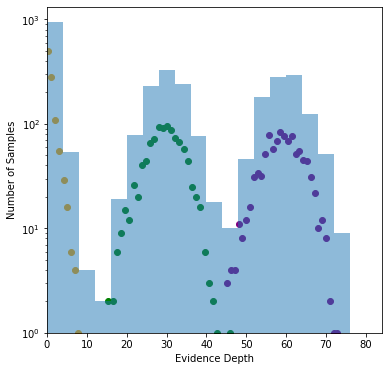

In [10]:
#pi, alpha, lambda_, mu, sigma, log_likelihoods_2 = SVMM_2mode(X, False, False)
pi, alpha, lambda_, mu, sigma, log_likelihoods_3 = SVMM_3mode(X, True, False)

In [23]:
BIC_2mode = BIC(log_likelihoods_2[-1], 2, len(X))
BIC_3mode = BIC(log_likelihoods_3[-1], 3, len(X))
print(BIC_2mode, BIC_3mode)

11658.842151336608 11716.087039639722


In [25]:
AIC_2mode = AIC(log_likelihoods_2[-1], len(X))
AIC_3mode = AIC(log_likelihoods_3[-1], len(X))
print(AIC_2mode, AIC_3mode)

16003628.438541498 16003624.876210125


In [26]:
MDL_2mode = MDL(log_likelihoods_2[-1], 2, len(X))
MDL_3mode = MDL(log_likelihoods_3[-1], 3, len(X))
print(MDL_2mode, MDL_3mode)

5829.421075668304 5858.043519819861
